In [95]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
from utils.utils import confidence_ellipse , save_fna

#Qiime
import qiime2 as q2
from qiime2.plugins.diversity.actions import alpha
from qiime2.plugins.feature_table.actions import rarefy
from qiime2.plugins.deicode.actions import rpca
from qiime2.plugins.gemelli.actions import ctf
from qiime2.plugins.diversity.actions import beta
from qiime2.plugins.songbird.actions import multinomial 
from qiime2.plugins.songbird.actions import summarize_paired 
from qiime2.plugins.qurro.actions import differential_plot
from qiime2.plugins.diversity.actions import alpha
from biom import Table, load_table

#Stats
from scipy.stats import sem
from skbio import OrdinationResults
from skbio import DistanceMatrix
from skbio.stats.distance import permanova
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
import statsmodels.api as sm
from scipy import stats

#Plotting
import plotnine as pn
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
%matplotlib inline

In [96]:
def get_q2(file):
    """Given path to model_fit.qzv, returns q2 score"""
    with ZipFile(file, 'r') as z:
        index_file=[x for x in z.namelist() if "index.html" in x][0]
        with z.open(index_file) as f:
            q2=f.readlines()[3].split()[-1].decode("utf-8") .replace("</p>",'')
            return(q2)

# Import data

In [97]:
#Data
root_dir="/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/"
bt = load_table(root_dir + "intermediate_data/20200611_filtered_metabolmics_table.biom")
#Make into cpm
bt.transform(lambda x,y,z: x*1000000)

#Metadata
md=pd.read_csv(root_dir + "intermediate_data/20200611_filtered_metabolomics_metadata.tsv", sep='\t', index_col=0)
md.index.name="sample_name"
doty_samples = set( md.query('qiita_study_id==11712').index )
swell_samples = set( md.query('qiita_study_id==11713').index )


#Spit by chorot
doty_bt = bt.filter(doty_samples, inplace=False)
swell_bt = bt.filter(swell_samples, inplace=False)

#Convert to qiime2
doty_qza = q2.Artifact.import_data('FeatureTable[Frequency]', doty_bt)
swell_qza = q2.Artifact.import_data('FeatureTable[Frequency]', swell_bt)

#Get feature metadata
met_md = pd.concat([swell_bt.metadata_to_dataframe(axis="observation"),doty_bt.metadata_to_dataframe(axis="observation")])
met_md = met_md.loc[~met_md.index.duplicated(keep='first')]

 Load beta diversity

In [4]:
jaccard_dms= {"doty":beta(table = doty_qza, metric="jaccard").distance_matrix.view(DistanceMatrix).to_data_frame(),
             "stillwell":beta(table = swell_qza, metric="jaccard").distance_matrix.view(DistanceMatrix).to_data_frame()}

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


# Time 0 vs time 7 comparison within sample type
No overall differences

In [5]:
out_list=[]

for sample_type in ["Stool","Oral","Skin"]:
    for study, dm in jaccard_dms.items():
        if study=="doty":
            md_ss = md.query('qiita_study_id==11712 & age in [0.0,7.0] & sample_type==@sample_type')
        else:
            md_ss = md.query('qiita_study_id==11713 & age in [0.0,7.0] & sample_type==@sample_type')
        if any(md_ss.age.value_counts() < 3) or not len(md_ss) or len(set(md_ss.age)) <2:
            print(study, sample_type)
            continue
        samples_keep = set(md_ss.index)
        dm_ss = dm.loc[samples_keep,samples_keep]
        temp_dm=DistanceMatrix(dm_ss, ids=dm_ss.index)
        pm = permanova(distance_matrix=temp_dm, grouping=md_ss, column="age")
        pm_df = pd.DataFrame(pm).transpose()
        pm_df["sample_type"] = sample_type
        pm_df["study"] = study
        out_list.append(pm_df)

perm_df = pd.concat(out_list)

stillwell Stool


In [77]:
perm_df

,method name,test statistic name,sample size,number of groups,test statistic,p-value,number of permutations,sample_type,study
PERMANOVA results,PERMANOVA,pseudo-F,58,2,2.53257,0.001,999,Stool,doty
PERMANOVA results,PERMANOVA,pseudo-F,58,2,1.38305,0.025,999,Oral,doty
PERMANOVA results,PERMANOVA,pseudo-F,15,2,0.871961,0.757,999,Oral,stillwell
PERMANOVA results,PERMANOVA,pseudo-F,58,2,1.20848,0.105,999,Skin,doty
PERMANOVA results,PERMANOVA,pseudo-F,16,2,1.06754,0.161,999,Skin,stillwell


# Jaccard Difference from baseline by individual

Get distances

In [12]:

out_list_j = []
for study, dm in jaccard_dms.items():
    if study=="doty":
        md_ss = md.query('qiita_study_id==11712')
        earliest_tp = 0
    else:
        md_ss = md.query('qiita_study_id==11713')
        earliest_tp = 1
    host_list = set( md_ss.host_subject_id )
    for host in host_list:
        for sample_type in ["Stool","Oral","Skin"]:
            host_md_ss = md_ss.query('host_subject_id==@host & sample_type==@sample_type')
            if not len(host_md_ss):
                continue
            earliest_sample = host_md_ss.query('age==@earliest_tp').index.values
            if not len(earliest_sample):
                continue
            d_mode = host_md_ss.delivery_mode[0]
            earliest_sample = earliest_sample[0]
            for s,row in host_md_ss.iterrows():
                temp_dist = dm.loc[earliest_sample,s]
                t = row.age
                abx= row.metadata_abx
                out_list_j.append([study,d_mode,host,sample_type,t,temp_dist, abx])
jdf = pd.DataFrame(out_list_j, columns=["study","delivery_mode","host_subject_id","sample_type","age","d", "abx"])


Linear regressions

In [14]:

lm_list = []
for study in ["doty","stillwell"]:
    for delivery_mode in ["c-section","vaginal"]:
        if study=="stillwell" and delivery_mode=="vaginal":
            continue
        for sample_type in ["Stool","Oral","Skin"]:
            temp = jdf.query('sample_type==@sample_type & study==@study & delivery_mode ==@delivery_mode ')
            if study=="stillwell":
                temp = temp.query('age not in [1,0]')
            else:
                temp = temp.query('age not in [0]')
            X = temp.age
            y = temp.d

            X2 = sm.add_constant(X)
            est = sm.OLS(y, X2)

            intercept = float(est.fit().summary().tables[1].data[1][1])
            slope = float(est.fit().summary().tables[1].data[2][1])
            pvalue=est.fit().f_pvalue
            Rsq = est.fit().summary().tables[0].data[0][3]

            lm_list.append([study,delivery_mode,sample_type,intercept,slope,Rsq, pvalue])
lm_df = pd.DataFrame(lm_list, columns=["study","delivery_mode","sample_type","intercept","slope","R2", "p"])
lm_df["sig"] = lm_df.p < .05

lm_df["all_info"] = lm_df.apply(axis=1, func=lambda row: "R2={}\nslope={}".format(row.R2.strip(),
                                                                             row.slope))
lm_df.style.bar("slope")

,study,delivery_mode,sample_type,intercept,slope,R2,p,sig,all_info
0,doty,c-section,Stool,0.7732,0.0174,0.151,0.0017965,True,R2=0.151 slope=0.0174
1,doty,c-section,Oral,0.6862,0.0134,0.146,0.000265655,True,R2=0.146 slope=0.0134
2,doty,c-section,Skin,0.742,-0.0001,0.000,0.965468,False,R2=0.000 slope=-0.0001
3,doty,vaginal,Stool,0.7608,0.0134,0.092,0.0165239,True,R2=0.092 slope=0.0134
4,doty,vaginal,Oral,0.7179,0.0013,0.002,0.708814,False,R2=0.002 slope=0.0013
5,doty,vaginal,Skin,0.722,-0.0006,0.000,0.873681,False,R2=0.000 slope=-0.0006
6,stillwell,c-section,Stool,0.6918,0.0127,0.199,0.000633434,True,R2=0.199 slope=0.0127
7,stillwell,c-section,Oral,0.7104,0.0024,0.010,0.418547,False,R2=0.010 slope=0.0024
8,stillwell,c-section,Skin,0.7243,-0.0003,0.000,0.936678,False,R2=0.000 slope=-0.0003


/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/svg/metabolomics_jaccard_distance_to_baseline.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/metabolomics_jaccard_distance_to_baseline.pdf
  warn('Filen

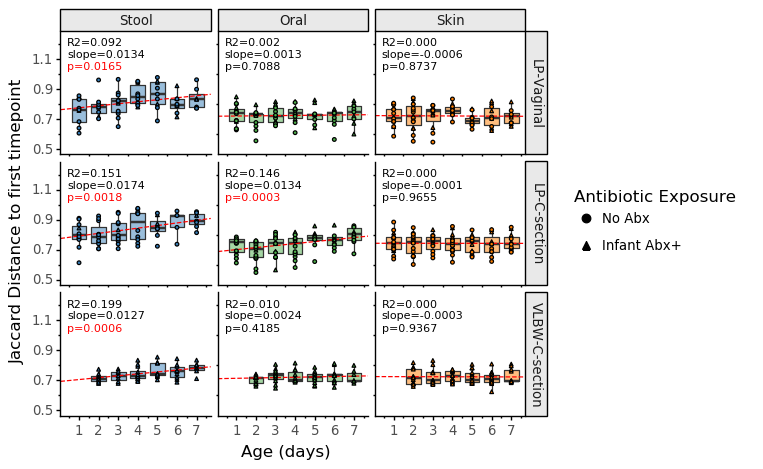

<ggplot: (8769509760972)>

In [18]:
pn.options.figure_size = (6,5)

colors=['#377eb8',  '#4daf4a','#ff7f00',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
rows_drop = set(jdf.query('study=="doty" & age ==0').index ) | set(jdf.query('study=="stillwell" & age in [0,1]').index )
plot_dat = jdf.query('index not in @rows_drop').copy()
plot_dat["sample_type"] = pd.Categorical(plot_dat.sample_type, categories=["Stool","Oral","Skin"], ordered=True)
plot_dat["weight"] = ["LP" if x=="doty" else "VLBW" for x in plot_dat.study]
sdm_dict = {"doty_c-section": "LP-C-section",
           "doty_vaginal":"LP-Vaginal",
           "stillwell_c-section":"VLBW-C-section"}
plot_dat["study_delivery_mode"] = plot_dat.apply(axis=1, func=lambda row: sdm_dict[row.study + "_" + row.delivery_mode])
plot_dat["study_delivery_mode"] = pd.Categorical(plot_dat["study_delivery_mode"], categories=["LP-Vaginal","LP-C-section","VLBW-C-section"])
abx_dict = {0: "No Abx",
           1: "Infant Abx+"}
plot_dat["abx_label"] = pd.Categorical([abx_dict[x] for x in plot_dat["abx"]], categories=["No Abx","Infant Abx+"])

#plot_dat["abx_category"]

lm_plot_dat= lm_df.copy()
lm_plot_dat["sample_type"] = pd.Categorical(lm_plot_dat.sample_type, categories=["Stool","Oral","Skin"], ordered=True)
lm_plot_dat['p'] = [round(x,4) for x in lm_plot_dat.p]
lm_plot_dat['p_text'] = ["p={}".format(x) for x in lm_plot_dat.p]
lm_plot_dat["weight"] = ["LP" if x=="doty" else "VLBW" for x in lm_plot_dat.study]
lm_plot_dat["study_delivery_mode"] = lm_plot_dat.apply(axis=1, func=lambda row: sdm_dict[row.study + "_" + row.delivery_mode])
lm_plot_dat["study_delivery_mode"] = pd.Categorical(lm_plot_dat["study_delivery_mode"], categories=["LP-Vaginal","LP-C-section","VLBW-C-section"])


p = (pn.ggplot(data = plot_dat) +
     pn.geom_boxplot( pn.aes(x="age",y="d", group="age", fill="sample_type"), outlier_alpha=0, alpha=.5) +
     pn.geom_abline(data = lm_plot_dat,  mapping=pn.aes(intercept="intercept", slope="slope"), color="red",linetype="dashed") +
     pn.geom_text(data = lm_plot_dat, mapping = pn.aes(x=.4,y=1.17, label="all_info"),size=8, hjust="left") +
     pn.geom_text(data = lm_plot_dat, mapping = pn.aes(x=.4,y=1.05, label="p_text", color="sig"),size=8, hjust="left") +
     pn.geom_point( pn.aes(x="age",y="d", group="age", shape="abx_label", fill="sample_type"), size=1, alpha=1, color="black") +
     pn.facet_grid('study_delivery_mode~sample_type', scales="free", space="free")+
     pn.scale_fill_manual(values=colors) +
     pn.scale_color_manual(values=["black","red"]) +
     pn.scale_shape_manual(values=["o","^","D"]) +
     pn.guides(color=None, fill=None) +
     pn.scale_y_continuous(limits=[.5,1.25]) +
     pn.scale_x_continuous(breaks=[0,1,2,3,4,5,6,7]) +
     pn.labs(x="Age (days)", y="Jaccard Distance to first timepoint", shape="Antibiotic Exposure") +
     pn.guides(shape = pn.guide_legend(override_aes={"size":3})) +
     pn.theme_classic(base_size=12) +
     pn.theme(strip_background=pn.element_rect(fill="#E9E9E9"))
     
    )
p.save(root_dir + "results/figures/svg/metabolomics_jaccard_distance_to_baseline.svg", dpi=300)
p.save(root_dir + "results/figures/metabolomics_jaccard_distance_to_baseline.pdf", dpi=300)
p

In [59]:
dmode_df = md.groupby("host_subject_id").agg({"delivery_mode":"first"})
jdf2 = jdf.merge(dmode_df, left_on="host_subject_id", right_index=True)


To run
#doty formula age + abx + delivery_mode
#doty formula age + abx + delivery_mode + randomization
#stillwell formula: age

# Songbird formula (age + delivery_mode)

In [7]:
pwd

'/projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/sw_notebooks'

100%|██████████| 53000/53000 [00:59<00:00, 884.36it/s]


20106 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.
11712 Stool q2:0.059769


100%|██████████| 16000/16000 [00:15<00:00, 1025.11it/s]


21291 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.
11713 Stool q2:-0.075843


100%|██████████| 50000/50000 [00:49<00:00, 1000.61it/s]


20999 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.
11712 Oral q2:0.010816


100%|██████████| 20000/20000 [00:19<00:00, 1041.02it/s]


21018 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.
11713 Oral q2:-0.025701


100%|██████████| 48000/48000 [00:35<00:00, 1334.42it/s]


22187 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.
11712 Skin q2:-0.001335


100%|██████████| 20000/20000 [00:20<00:00, 963.27it/s]


20830 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.
11713 Skin q2:-0.058547


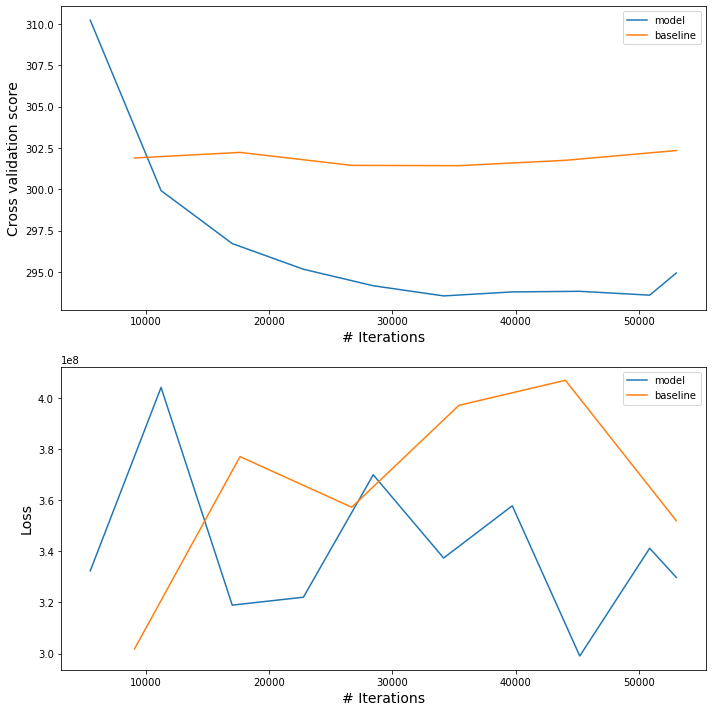

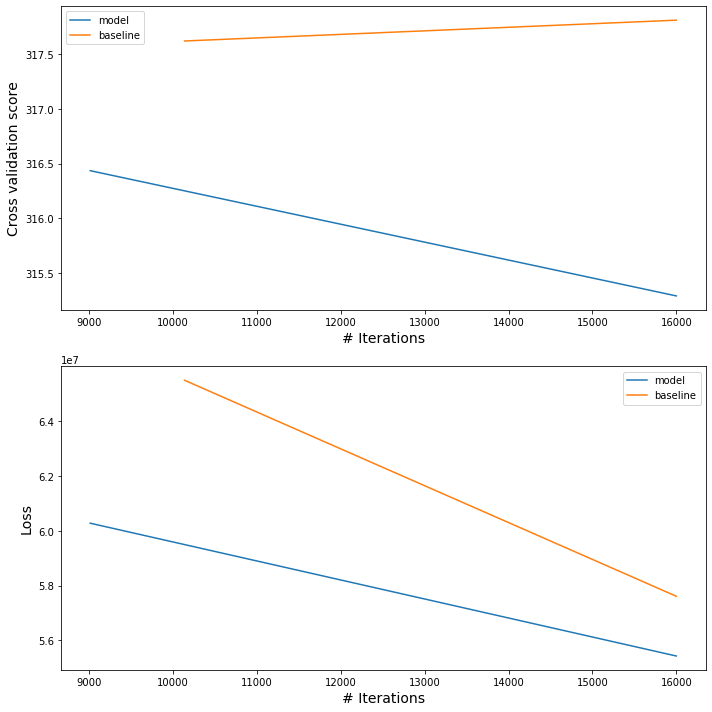

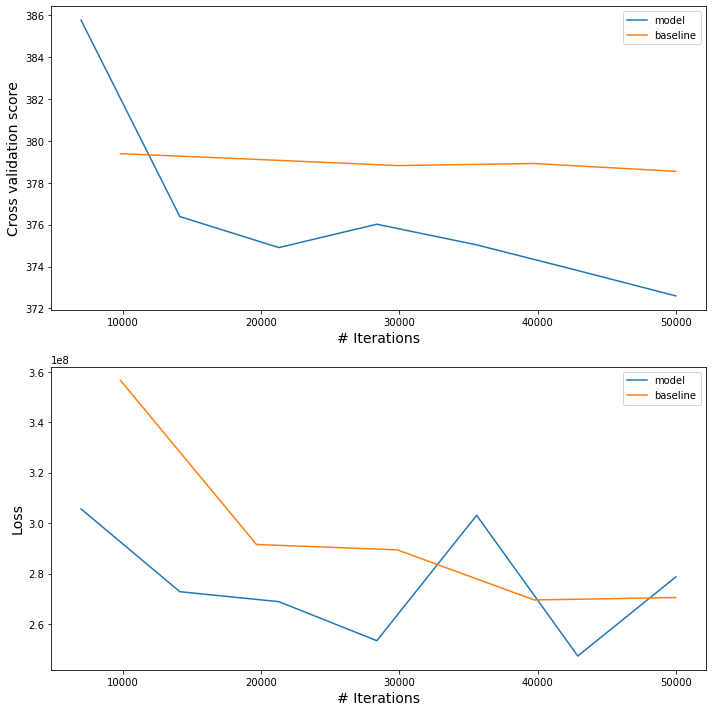

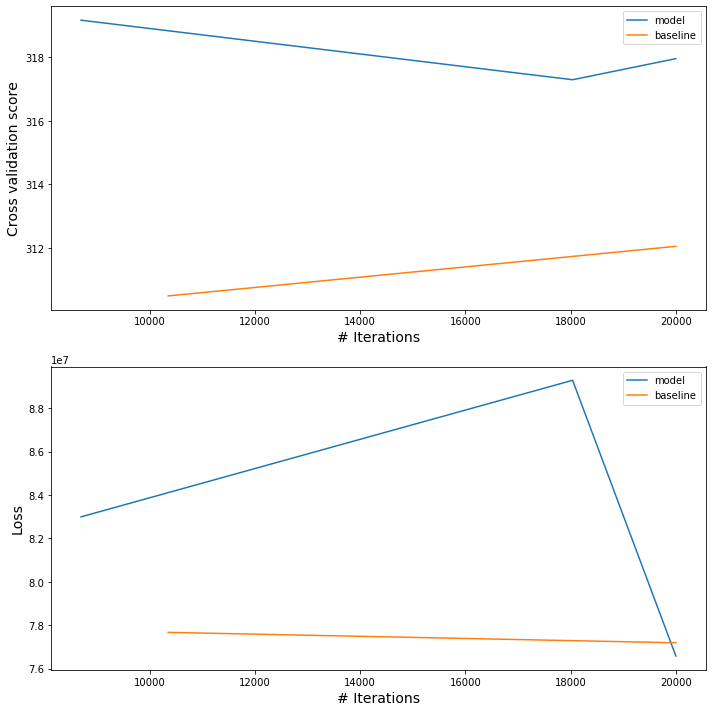

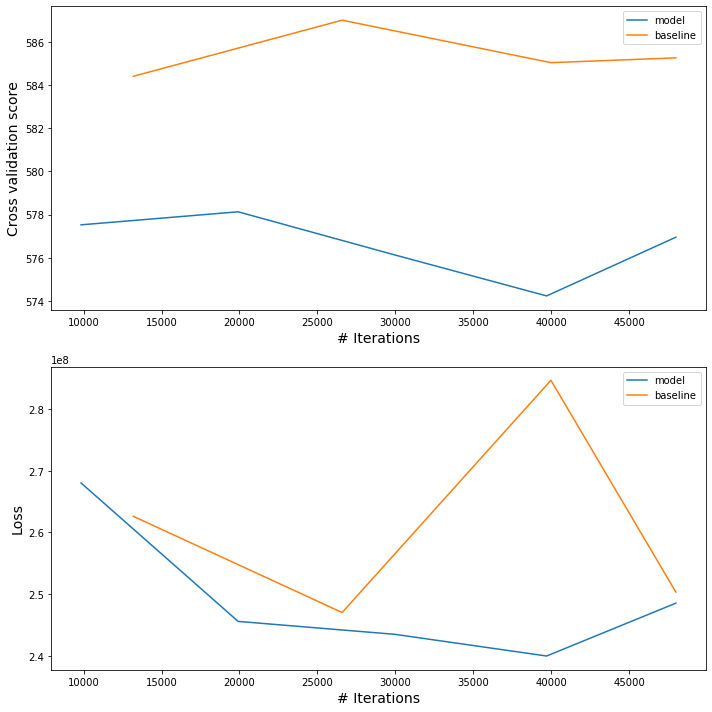

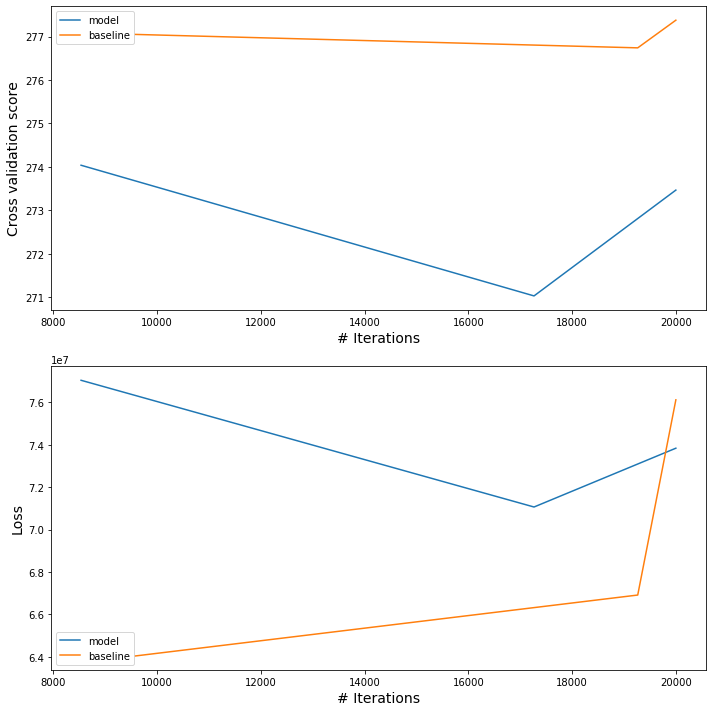

In [12]:
#Run/Import Songbird
out_folder= root_dir + "/intermediate_data/songbird_deliverymode/"
!mkdir -p $out_folder

songbird_delmode_dict = {x:{} for x in set(md.qiita_study_id)}



for sample_type in ["Stool","Oral","Skin"]:
    for study in set(md.qiita_study_id):
        md_ss = md.query('qiita_study_id==@study  & sample_type==@sample_type')
        samples_keep = set(md_ss.index)
        if study ==11712:
            temp_bt = doty_bt.filter(samples_keep, inplace=False)
            formula = "age + delivery_mode + metadata_abx"
        else:
            temp_bt = swell_bt.filter(samples_keep, inplace=False)
            formula= "age"
        #Make feature metadata
        temp_feature_md = temp_bt.metadata_to_dataframe("observation").drop(columns=['CAS_Number','INCHI','IonMode','Smiles'])
        #Filter to only named compounds
        #temp_feature_md = temp_feature_md.query('Compound_Name != "nan"')
        temp_feature_md.index.name="featureid"
        #Convert data to qza
        temp_qza = q2.Artifact.import_data('FeatureTable[Frequency]', temp_bt)
        temp_md_qza = q2.Metadata(md_ss)
        temp_feature_md_qza = q2.Metadata(temp_feature_md)
        #Run songbird
        (temp_differentials,
         temp_regression_stats,
         temp_regression_biplot) = multinomial(table=temp_qza,
                                               metadata=temp_md_qza,
                                               formula=formula)
        
        #Run null model (just sex)
        (null_differentials,
         null_regression_stats,
         null_regression_biplot) = multinomial(table=temp_qza,
                                               metadata=temp_md_qza,
                                               formula="1")
        #Run qurro
        tmp_qurro = differential_plot(ranks= temp_differentials,
                                        table= temp_qza,
                                        sample_metadata=temp_md_qza,
                                       feature_metadata=temp_feature_md_qza).visualization
        #Evaluate model fit
        tmp_model_fit = summarize_paired(regression_stats = temp_regression_stats,
                                        baseline_stats = null_regression_stats).visualization
        #Add outputs to master dictionary
        songbird_delmode_dict[study][sample_type] = {}
        songbird_delmode_dict[study][sample_type]["differentials"] = temp_differentials
        songbird_delmode_dict[study][sample_type]["regression_stats"] = temp_regression_stats
        songbird_delmode_dict[study][sample_type]["regression_biplot"] = temp_regression_biplot
        songbird_delmode_dict[study][sample_type]["qurro"] = tmp_qurro
        songbird_delmode_dict[study][sample_type]["model_fit"] = tmp_model_fit
        #Save outputs
        temp_differentials.save(out_folder + "{}_{}_differentials.qza".format(study,sample_type))
        temp_regression_stats.save(out_folder + "{}_{}_regression_stats.qza".format(study,sample_type))
        temp_regression_biplot.save(out_folder + "{}_{}_regression_biplot.qza".format(study,sample_type))
        tmp_qurro.save(out_folder + "{}_{}_qurro.qzv".format(study,sample_type))
        tmp_model_fit.save(out_folder + "{}_{}_model_fit.qzv".format(study,sample_type))
        
        #Get q2
        q_square = get_q2(out_folder + "{}_{}_model_fit.qzv".format(study,sample_type))
        songbird_delmode_dict[study][sample_type]["q_square"] = q_square
        print("{} {} q2:{}".format(study, sample_type, q_square))
                                                    

In [15]:
met_md.head()

,Adduct,Annotation,Bile_Acid_Class,Bile_Acid_Subclass,CAS_Number,Compound_Name,Compound_Source,INCHI,IonMode,LibMZ,LibraryQualityString,Smiles,StandardMatch,Structural_Classification,Structural_Identification,row_m_z,row_retention_time
365.1063;0.2553,[M+Na]+,nan,nan,nan,nan,Melibiose,isolated,InChI=1S/C12H22O11/c13-1-3-5(14)8(17)10(19)12(...,positive,365.105,Bronze,nan,nan,nan,nan,nan,nan
158.1547;4.8705,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
192.979;12.3976,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
242.2907;6.9078,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
339.3473;9.2091,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [357]:
md_ss.milk.value_counts()

formula       136
donor_milk    135
Name: milk, dtype: int64

In [359]:
md.groupby("study_delivery_mode").milk.value_counts()

study_delivery_mode  milk      
LPI-C-section        formula       228
                     donor_milk    193
LPI-Vaginal          formula       182
                     donor_milk    171
VLBW-C-section       mom_milk      217
                     donor_milk     89
Name: milk, dtype: int64

100%|██████████| 53000/53000 [01:30<00:00, 588.52it/s]


20106 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.
11712 Stool q2:0.016611


100%|██████████| 50000/50000 [01:14<00:00, 666.75it/s]


20999 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.
11712 Oral q2:0.045063


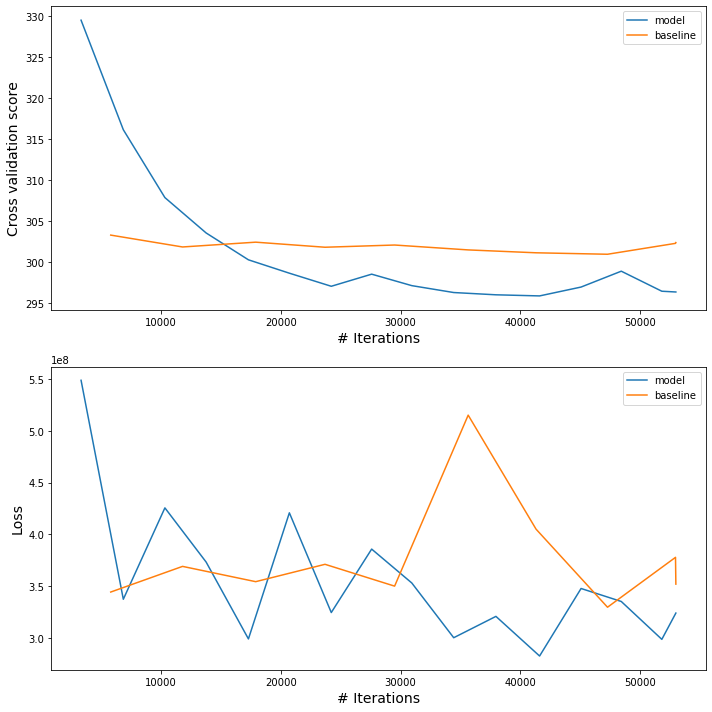

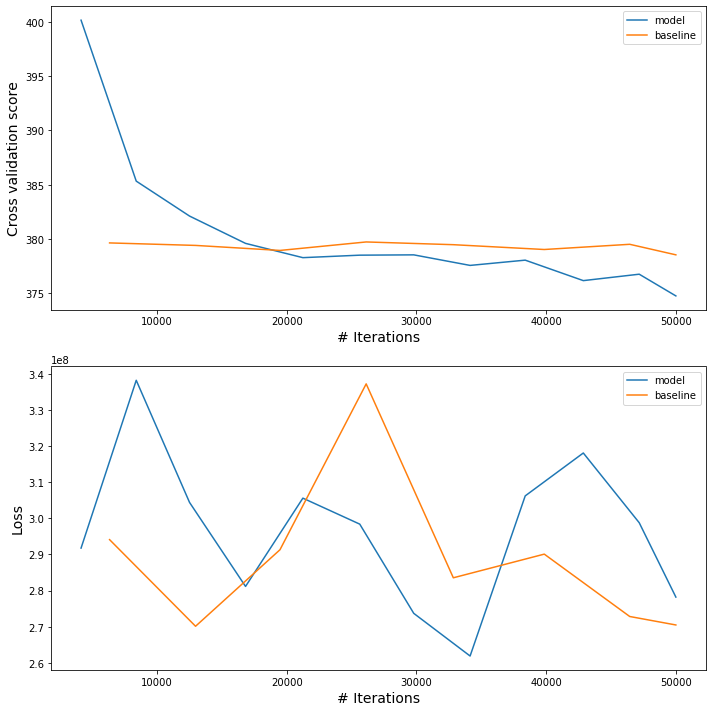

In [361]:
#Run/Import Songbird
out_folder= root_dir + "/intermediate_data/songbird_randomization/"
!mkdir -p $out_folder

md["milk"] = md.randomization.replace({"mother's own milk":"mom_milk",
                                      "Donor human milk":"donor_milk",
                                      "Formula":"formula"})

songbird_randomization_dict = {}
study=11712
formula= "delivery_mode + age  + metadata_abx + milk"

for sample_type in ["Stool","Oral"]:
    md_ss = md.query('qiita_study_id==@study  & sample_type==@sample_type')
    samples_keep = set(md_ss.index)
    if study ==11712:
        temp_bt = doty_bt.filter(samples_keep, inplace=False)
        
    #Make feature metadata
    temp_feature_md = temp_bt.metadata_to_dataframe("observation").loc[:,["Compound_Name"]]
    #Filter to only named compounds
    #temp_feature_md = temp_feature_md.query('Compound_Name != "nan"')
    temp_feature_md.index.name="featureid"
    #Convert data to qza
    temp_qza = q2.Artifact.import_data('FeatureTable[Frequency]', temp_bt)
    temp_md_qza = q2.Metadata(md_ss)
    temp_feature_md_qza = q2.Metadata(temp_feature_md)
    #Run songbird
    (temp_differentials,
     temp_regression_stats,
     temp_regression_biplot) = multinomial(table=temp_qza,
                                           metadata=temp_md_qza,
                                           formula=formula)

    #Run null model (just sex)
    (null_differentials,
     null_regression_stats,
     null_regression_biplot) = multinomial(table=temp_qza,
                                           metadata=temp_md_qza,
                                           formula="1")
    #Run qurro
    tmp_qurro = differential_plot(ranks= temp_differentials,
                                    table= temp_qza,
                                    sample_metadata=temp_md_qza,
                                   feature_metadata=temp_feature_md_qza).visualization
    #Evaluate model fit
    tmp_model_fit = summarize_paired(regression_stats = temp_regression_stats,
                                    baseline_stats = null_regression_stats).visualization
    #Add outputs to master dictionary
    songbird_randomization_dict[sample_type] = {}
    songbird_randomization_dict[sample_type]["differentials"] = temp_differentials
    songbird_randomization_dict[sample_type]["regression_stats"] = temp_regression_stats
    songbird_randomization_dict[sample_type]["regression_biplot"] = temp_regression_biplot
    songbird_randomization_dict[sample_type]["qurro"] = tmp_qurro
    songbird_randomization_dict[sample_type]["model_fit"] = tmp_model_fit
    #Save outputs
    temp_differentials.save(out_folder + "{}_{}_differentials.qza".format(study,sample_type))
    temp_regression_stats.save(out_folder + "{}_{}_regression_stats.qza".format(study,sample_type))
    temp_regression_biplot.save(out_folder + "{}_{}_regression_biplot.qza".format(study,sample_type))
    tmp_qurro.save(out_folder + "{}_{}_qurro.qzv".format(study,sample_type))
    tmp_model_fit.save(out_folder + "{}_{}_model_fit.qzv".format(study,sample_type))

    #Get q2
    q_square = get_q2(out_folder + "{}_{}_model_fit.qzv".format(study,sample_type))
    songbird_randomization_dict[sample_type]["q_square"] = q_square
    print("{} {} q2:{}".format(study, sample_type, q_square))
                                                    

Compare Q2s

In [377]:
songbird_delmode_dict[11712]["Stool"].keys()

dict_keys(['differentials', 'regression_stats', 'regression_biplot', 'qurro', 'model_fit'])

In [380]:
#No randomization
print("formula: age + delivery_mode + metadata_abx")
for k,v in songbird_delmode_dict.items():
    for k2,v2 in v.items():
        print(k,k2,v2["q_square"])

formula: age + delivery_mode + metadata_abx
11712 Stool 0.052939
11712 Oral 0.009355
11712 Skin 0.066194
11713 Stool -0.060137
11713 Oral -0.102907
11713 Skin -0.046626


In [373]:
print("formula: age + delivery_mode + metadata_abx + milk")
for k,v in songbird_randomization_dict.items():
    print("11712",k,v["q_square"])

formula: age + delivery_mode + metadata_abx + milk
11712 Stool 0.016611
11712 Oral 0.045063


Load precomputed Songbird

In [4]:
!ls $root_dir/intermediate_data/songbird_randomization/

11712_Oral_differentials.qza	  11712_Stool_differentials.qza
11712_Oral_model_fit.qzv	  11712_Stool_model_fit.qzv
11712_Oral_qurro.qzv		  11712_Stool_qurro.qzv
11712_Oral_regression_biplot.qza  11712_Stool_regression_biplot.qza
11712_Oral_regression_stats.qza   11712_Stool_regression_stats.qza


In [174]:
out_folder= root_dir + "/intermediate_data/songbird_randomization/"
songbird_randomization_dict={}
study="11712"
songbird_randomization_dict[study] = {}
for sample_type in ["Stool","Oral"]:        
    songbird_randomization_dict[study][sample_type] = {}
    songbird_randomization_dict[study][sample_type]["differentials"] = q2.Artifact.load(out_folder + "{}_{}_differentials.qza".format(study,sample_type))
    songbird_randomization_dict[study][sample_type]["regression_stats"] = q2.Artifact.load(out_folder + "{}_{}_regression_stats.qza".format(study,sample_type))
    songbird_randomization_dict[study][sample_type]["regression_biplot"] = q2.Artifact.load(out_folder + "{}_{}_regression_biplot.qza".format(study,sample_type))
    songbird_randomization_dict[study][sample_type]["qurro"] = q2.Visualization.load(out_folder + "{}_{}_qurro.qzv".format(study,sample_type))
    songbird_randomization_dict[study][sample_type]["model_fit"] = q2.Visualization.load(out_folder + "{}_{}_model_fit.qzv".format(study,sample_type))

In [175]:
name_conversion={
    "Spectral Match to His-Pro from NIST14":"His-Pro",
    "Spectral Match to Conjugated linoleic Acid (10E,12Z) from NIST14":"Conjugated linoleic Acid",
    "Spectral Match to Taurocholic acid from NIST14":"Taurocholic acid",
    "Spectral Match to Glycocholic acid from NIST14":"Glycocholic acid"
}
def fix_name(x):
    try:
        return(name_conversion[x])
    except KeyError:
        return(x)
def get_top_list(sbd, study, sample_type, factor, i):
    if study:
        temp_df = sbd[study][sample_type]["differentials"].view(pd.DataFrame).merge(met_md, right_index=True, left_index=True)
    else:
        temp_df = sbd[sample_type]["differentials"].view(pd.DataFrame).merge(met_md, right_index=True, left_index=True)
    temp_df = temp_df.query('Compound_Name != "nan"')
    temp_df = temp_df.sort_values(factor, ascending=False)
    temp_df_ss = temp_df.iloc[top_bottom(i)].copy()
    temp_df_ss = temp_df_ss.reset_index().loc[:,["Compound_Name",factor,"Bile_Acid_Class" ]]
    #Convert name if delivery mode
    compare_conversion={"C(study_delivery_mode, Treatment('LPI-Vaginal'))[T.LPI-C-section]":"LPI-Vaginal | LPI-C-section",
                   "C(study_delivery_mode, Treatment('LPI-Vaginal'))[T.VLBW-C-section]":"LPI-Vaginal | VLBW-C-section"}
    if factor in compare_conversion.keys():
        temp_df_ss = temp_df_ss.rename(columns={factor:compare_conversion[factor] })
    return(temp_df_ss)

def get_increasing_list(sbd, study, sample_type, factor, i,direction):
    if study:
        temp_df = sbd[study][sample_type]["differentials"].view(pd.DataFrame).merge(met_md, right_index=True, left_index=True)
    else:
        temp_df = sbd[sample_type]["differentials"].view(pd.DataFrame).merge(met_md, right_index=True, left_index=True)
    temp_df = temp_df.query('Compound_Name != "nan"')
    temp_df = temp_df.sort_values(factor, ascending=False)
    if direction=="+":
        temp_df_ss = temp_df.iloc[range(i)].copy()
    else:
        temp_df_ss = temp_df.iloc[[-x for x in range(1,i+1)]].copy()
    temp_df_ss = temp_df_ss.reset_index().loc[:,["Compound_Name",factor ]]
    temp_df_ss["Compound_Name"] = temp_df_ss["Compound_Name"].apply(fix_name)
    temp_df_ss.columns=["Compound Name","Songbird Differential"]
    #Convert name if delivery mode
    compare_conversion={"C(study_delivery_mode, Treatment('LPI-Vaginal'))[T.LPI-C-section]":"LPI-Vaginal | LPI-C-section",
                   "C(study_delivery_mode, Treatment('LPI-Vaginal'))[T.VLBW-C-section]":"LPI-Vaginal | VLBW-C-section"}
    if factor in compare_conversion.keys():
        temp_df_ss = temp_df_ss.rename(columns={factor:compare_conversion[factor] })
    return(temp_df_ss)


In [28]:
from IPython.display import HTML

th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'black'),
  ('background-color', '#f7f7f9'),
    ('font-family','Helvetica')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '11px'),
    ('text-align', 'center')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]

n=5

inc_1= get_increasing_list(songbird_randomization_dict, '11712', "Stool","age",n,"+")
#inc_2= get_increasing_list(songbird_randomization_dict, '11712', "Oral","age",n,"+")

dec_1= get_increasing_list(songbird_randomization_dict, '11712', "Stool","age",n,"-")
#dec_2= get_increasing_list(songbird_randomization_dict, '11712', "Oral","age",n,"-")

head = """
<table>
    <thead>
        <th> </th>
        <th style="text-align: center; font-size:18px; font-family:Helvetica">Stool</th>
    </thead>
    </tbody>

"""
rows = {"Increasing\nwith\nage":[inc_1],
       "Decreasing\nwith\nage":[dec_1]}

for k,v in rows.items():
    row = '<tr><th style="text-align: center; font-size:14px; vertical-align: center; font-family:Helvetica">{}</th>'.format(k)
    for serie in v:
        s = serie.copy()
        s.index=range(1,n+1)
        s.name=''
        if s.iloc[1,1] > 0:
            row += "<td>{}</td>".format(s.style.bar(align="mid",vmin=0,vmax=1.1,
                                                                color=['#67a9cf'],
                                                               width=100).format({'Songbird Differential': "{:.3}"}).set_table_styles(styles).render()) #testn['width']
        else:
            row += "<td>{}</td>".format(s.style.bar(align="mid",vmax=0,vmin=-1.1,
                                                            color=['#ef8a62'],
                                                           width=100).format({'Songbird Differential': "{:.3}"}).set_table_styles(styles).render()) #testn['width']
    row += '</tr>'
    head += row

head+= """
</tbody>
</table>"""





out_folder= root_dir + "/results/tables/"
with open(out_folder + "metabolomics_age_table.html", 'w') as f:
    f.write(head)
HTML(head)

In [178]:
songbird_randomization_dict[11712, "Stool"]

KeyError: (11712, 'Stool')

In [401]:
get_top_list(songbird_delmode_dict,11713, "Stool","age",5).style.bar("age", align="mid")

,Compound_Name,age,Bile_Acid_Class
0,Blood Group B Trisaccharide,0.520238,nan
1,LNFP V,0.510422,nan
2,LNFP III,0.502287,nan
3,desmethylenylnocardamine,0.458563,nan
4,cis-Vaccenic acid,0.448739,nan
5,Spectral Match to Glycan Lacto-N-biose from NIST14,-0.427209,nan
6,Tauroursodeoxycholic acid,-0.429601,Primary
7,D-erythro-Sphinganine,-0.437326,nan
8,GLYCOCHENODEOXYCHOLIC ACID,-0.576388,Primary
9,Spectral Match to 9(10)-EpOME from NIST14,-0.590088,nan


In [400]:
get_top_list(songbird_randomization_dict,0, "Stool","milk[T.formula]",5).style.bar(align="mid")

,Compound_Name,milk[T.formula],Bile_Acid_Class
0,Leu Asn Thr,1.9693,nan
1,Ala-Met,1.72201,nan
2,"NCGC00380778-01_C9H14N2O3_(3S,8aS)-3-[(1R)-1-Hydroxyethyl]hexahydropyrrolo[1,2-a]pyrazine-1,4-dione",1.56826,nan
3,Melibiose,1.55329,nan
4,Spectral Match to Val-Ile from NIST14,1.55248,nan
5,Spectral Match to Ampicillin from NIST14,-1.93939,nan
6,Blood Group A Tetrasaccharide,-2.32697,nan
7,DL-.beta.-Hydroxypalmitic acid,-2.51216,nan
8,"NCGC00186665-03!2,3-dihydroxypropyl hexadecanoate",-3.15836,nan
9,Spectral Match to His-Pro from NIST14,-4.75136,nan


In [317]:
doty_stool_diffs = songbird_delmode_dict[11712]["Stool"]["differentials"].view(pd.DataFrame)
doty_stool_diffs = doty_stool_diffs.merge(doty_bt.metadata_to_dataframe("observation").loc[:,["Compound_Name"]], right_index=True, left_index=True)
doty_stool_diffs = doty_stool_diffs.query('Compound_Name!="nan"').sort_values("age", ascending=False)


- Vaccenic acid: predominant kind of trans-fatty acid in human milk
- 

In [362]:
notes = {
"cis-Vaccenic acid": "predominant kind of trans-fatty acid in human milk",
"Linoleic acid methyl ester":" essential fatty acid in human milk",
"Oleic acid ethyl ester": "fatty acid in human milk",
    "Dibenzylamine":"rubber biproduct",
    "NCGC00380283-01!4-[5-[[4-[5-[acetyl(hydroxy)amino]pentylamino]-4-oxobutanoyl]-hydroxyamino]pentylamino]-4-oxobutanoic acid":"short chain fatty acid",
"Spectral Match to Taurocholic acid from NIST14":"Primary conj. bile acid",
"Glycocholic acid":"Primary conj. bile acid",
 "Spectral Match to Glycocholic acid from NIST14":"Primary conj. bile acid",   

}

def add_notes(x):
    try:
        return(notes[x])
    except:
        return(" ")
    
def top_bottom(x):
    r1 = [i for i in range(x)]
    r2=[-i for i in range(1,x+1)]
    r2.reverse()
    return(r1+r2)
doty_stool_diffs["notes"] = doty_stool_diffs.Compound_Name.apply(add_notes)


# Songbird antibiotics

100%|██████████| 40000/40000 [00:39<00:00, 1024.71it/s]


20608 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.
11712 Stool q2:-0.005904


100%|██████████| 12000/12000 [00:07<00:00, 1570.26it/s]


22680 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.
11712 Stool q2:-0.065253


100%|██████████| 37000/37000 [00:31<00:00, 1191.43it/s]


21338 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.
11712 Oral q2:-0.012247


100%|██████████| 11000/11000 [00:07<00:00, 1504.32it/s]


22624 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.
11712 Oral q2:-0.149993


100%|██████████| 35000/35000 [00:23<00:00, 1489.53it/s]


22383 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.
11712 Skin q2:-0.003156


100%|██████████| 11000/11000 [00:06<00:00, 1785.29it/s]


23162 feature(s) in the BIOM table were not present in the feature rankings.
These feature(s) have been removed from the visualization.
11712 Skin q2:-0.173626


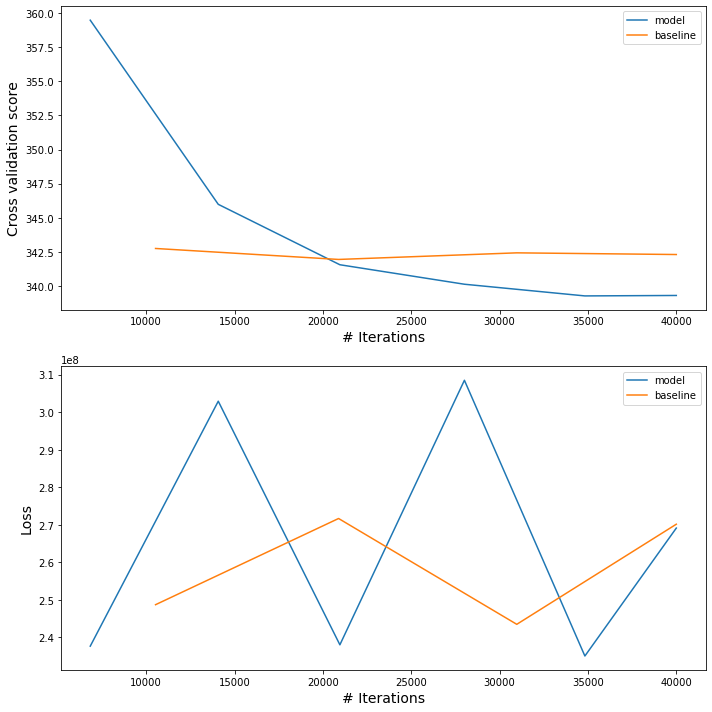

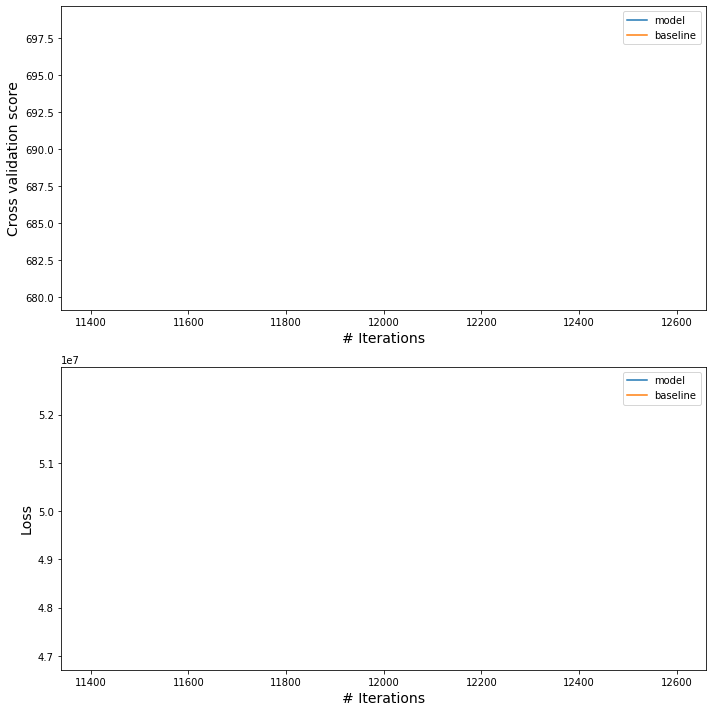

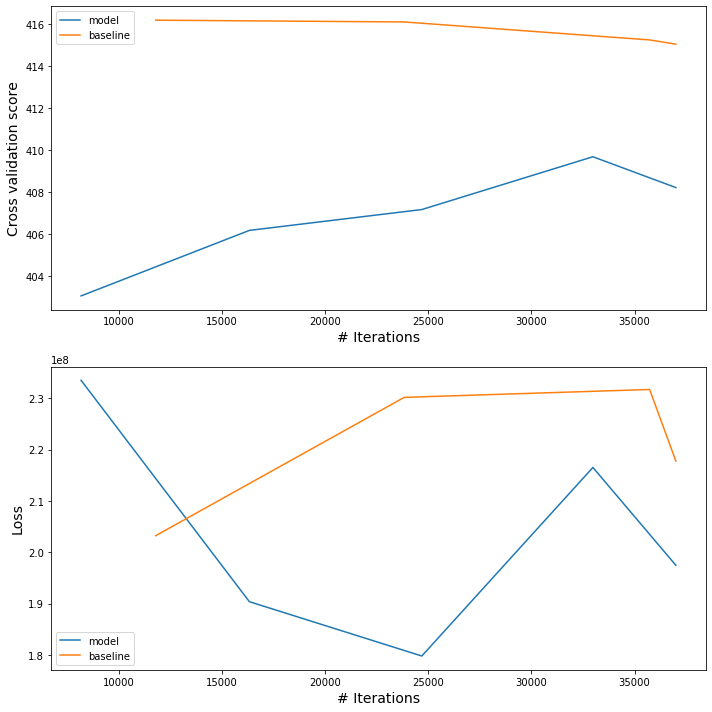

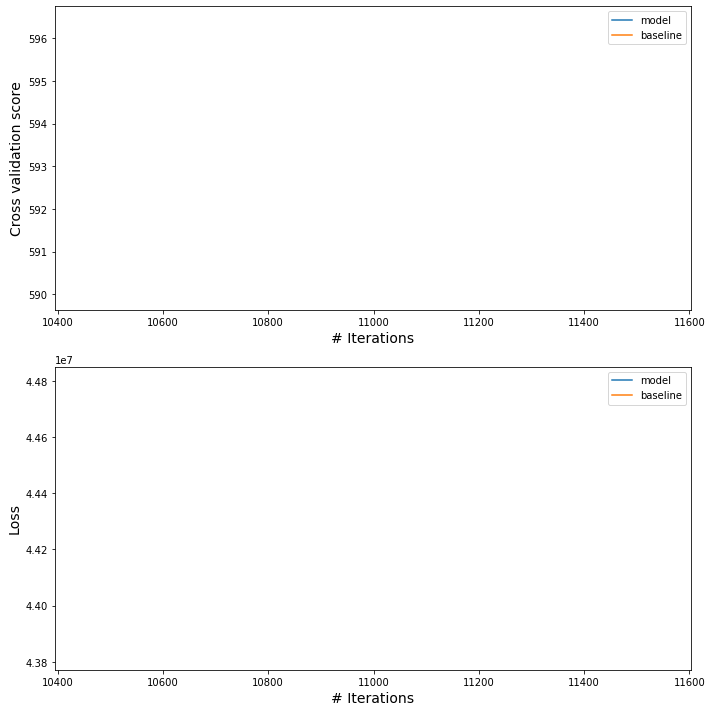

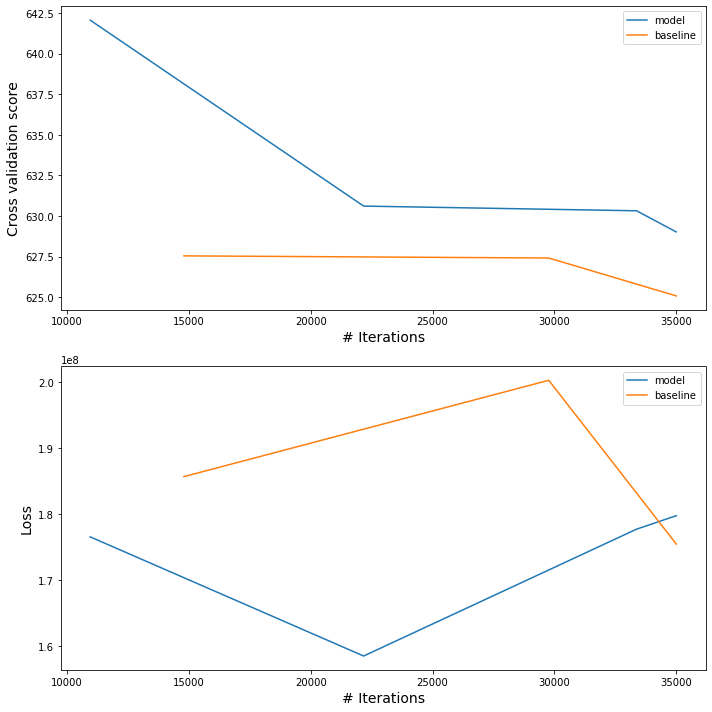

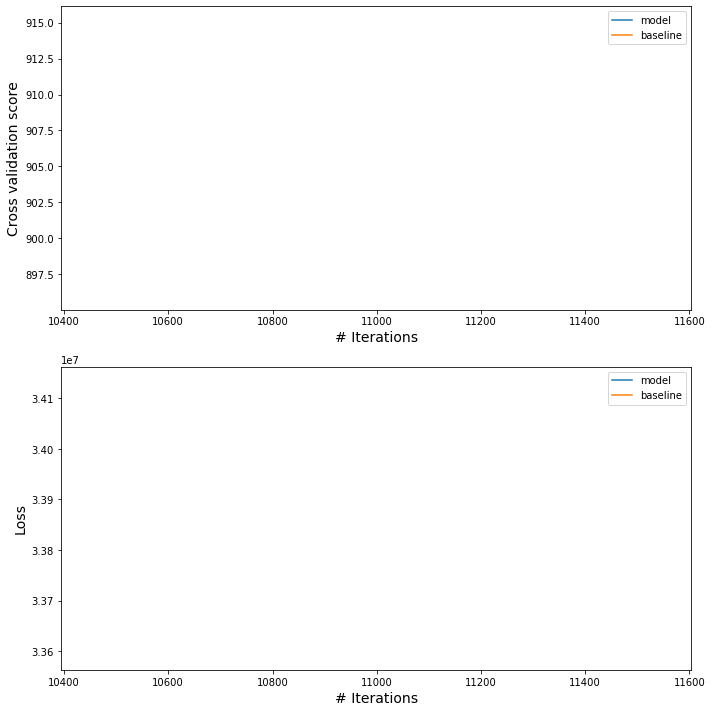

In [41]:
#Run/Import Songbird
out_folder= root_dir + "/intermediate_data/met_songbird_abx/"
!mkdir -p $out_folder

md["milk"] = md.randomization.replace({"mother's own milk":"mom_milk",
                                      "Donor human milk":"donor_milk",
                                      "Formula":"formula"})

songbird_abx_dict = {}
study=11712
formula= "delivery_mode + age  + milk"

for sample_type in ["Stool","Oral","Skin"]:
    songbird_abx_dict[sample_type] = {}
    for abx in [0,1]:
        md_ss = md.query('qiita_study_id==@study  & sample_type==@sample_type & metadata_abx==@abx')
        samples_keep = set(md_ss.index)
        if study ==11712:
            temp_bt = doty_bt.filter(samples_keep, inplace=False)

        #Make feature metadata
        temp_feature_md = temp_bt.metadata_to_dataframe("observation").loc[:,["Compound_Name"]]
        #Filter to only named compounds
        #temp_feature_md = temp_feature_md.query('Compound_Name != "nan"')
        temp_feature_md.index.name="featureid"
        #Convert data to qza
        temp_qza = q2.Artifact.import_data('FeatureTable[Frequency]', temp_bt)
        temp_md_qza = q2.Metadata(md_ss)
        temp_feature_md_qza = q2.Metadata(temp_feature_md)
        #Run songbird
        (temp_differentials,
         temp_regression_stats,
         temp_regression_biplot) = multinomial(table=temp_qza,
                                               metadata=temp_md_qza,
                                               formula=formula)

        #Run null model (just sex)
        (null_differentials,
         null_regression_stats,
         null_regression_biplot) = multinomial(table=temp_qza,
                                               metadata=temp_md_qza,
                                               formula="1")
        #Run qurro
        tmp_qurro = differential_plot(ranks= temp_differentials,
                                        table= temp_qza,
                                        sample_metadata=temp_md_qza,
                                       feature_metadata=temp_feature_md_qza).visualization
        #Evaluate model fit
        tmp_model_fit = summarize_paired(regression_stats = temp_regression_stats,
                                        baseline_stats = null_regression_stats).visualization
        #Add outputs to master dictionary
        songbird_abx_dict[sample_type][abx] = {}
        songbird_abx_dict[sample_type][abx]["differentials"] = temp_differentials
        songbird_abx_dict[sample_type][abx]["regression_stats"] = temp_regression_stats
        songbird_abx_dict[sample_type][abx]["regression_biplot"] = temp_regression_biplot
        songbird_abx_dict[sample_type][abx]["qurro"] = tmp_qurro
        songbird_abx_dict[sample_type][abx]["model_fit"] = tmp_model_fit
        #Save outputs
        temp_differentials.save(out_folder + "{}_{}_differentials.qza".format(study,sample_type))
        temp_regression_stats.save(out_folder + "{}_{}_regression_stats.qza".format(study,sample_type))
        temp_regression_biplot.save(out_folder + "{}_{}_regression_biplot.qza".format(study,sample_type))
        tmp_qurro.save(out_folder + "{}_{}_qurro.qzv".format(study,sample_type))
        tmp_model_fit.save(out_folder + "{}_{}_model_fit.qzv".format(study,sample_type))

        #Get q2
        q_square = get_q2(out_folder + "{}_{}_model_fit.qzv".format(study,sample_type))
        songbird_abx_dict[sample_type][abx]["q_square"] = q_square
        print("{} {} q2:{}".format(study, sample_type, q_square))
                                                    

# Alpha diversity

In [141]:
?alpha

In [46]:
md_alpha = md.copy()

alpha_list = []
for study, qza in zip(["doty","stillwell"],[doty_qza, swell_qza]):
    alpha_series = alpha(qza, metric="shannon").alpha_diversity.view(pd.Series)
    alpha_list.append(alpha_series)
alpha_df = pd.concat(alpha_list)
    
md_alpha = md_alpha.merge(alpha_df, right_index=True, left_index=True, how="outer")

In [49]:
md_alpha.qiita_study_id[0]

11712

In [52]:
md_alpha

,abx,abx_any_source,abx_exposure,abx_units,age,age_units,anonymized_name,any_formula,any_mbm,any_mbm_dc,...,wlz_avg,wlz_avg_bin,wlz_avg_diff,day_of_first_any_feed,days_to_any_feed,days_to_bm,any_fed_yet,bm_yet,temp,shannon
11712.SUBJECT1.ORAL.1,0,1,No,days,1.0,days,SUBJECT1.ORAL.1,Yes,Yes,Yes,...,missing: not collected,missing: not collected,missing: not collected,1,0,-4.0,1,0,LPI-C-section0.0,8.523412
11712.SUBJECT1.ORAL.2,0,0,No,days,2.0,days,SUBJECT1.ORAL.2,Yes,Yes,Yes,...,missing: not collected,missing: not collected,missing: not collected,1,1,-3.0,1,0,LPI-C-section0.0,6.726020
11712.SUBJECT1.ORAL.3,0,0,No,days,3.0,days,SUBJECT1.ORAL.3,Yes,Yes,Yes,...,missing: not collected,missing: not collected,missing: not collected,1,2,-2.0,1,0,LPI-C-section0.0,8.339321
11712.SUBJECT1.ORAL.4,0,0,No,days,4.0,days,SUBJECT1.ORAL.4,Yes,Yes,Yes,...,missing: not collected,missing: not collected,missing: not collected,1,3,-1.0,1,0,LPI-C-section0.0,8.542932
11712.SUBJECT1.ORAL.6,0,0,No,days,6.0,days,SUBJECT1.ORAL.6,Yes,Yes,Yes,...,missing: not collected,missing: not collected,missing: not collected,1,5,1.0,1,1,LPI-C-section0.0,8.347550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11713.8.S.8C,missing: not collected,1,missing: not collected,not applicable,3.0,days,8.S.8C,missing: not collected,missing: not collected,missing: not collected,...,missing: not collected,missing: not collected,missing: not collected,1,2,not_collected,1,not_collected,VLBW-C-section1.0,7.953259
11713.8.S.8D,missing: not collected,1,missing: not collected,not applicable,4.0,days,8.S.8D,missing: not collected,missing: not collected,missing: not collected,...,missing: not collected,missing: not collected,missing: not collected,1,3,not_collected,1,not_collected,VLBW-C-section1.0,8.419231
11713.8.S.8E,missing: not collected,1,missing: not collected,not applicable,5.0,days,8.S.8E,missing: not collected,missing: not collected,missing: not collected,...,missing: not collected,missing: not collected,missing: not collected,1,4,not_collected,1,not_collected,VLBW-C-section1.0,8.604872
11713.8.S.8F,missing: not collected,1,missing: not collected,not applicable,6.0,days,8.S.8F,missing: not collected,missing: not collected,missing: not collected,...,missing: not collected,missing: not collected,missing: not collected,1,5,not_collected,1,not_collected,VLBW-C-section1.0,8.958123


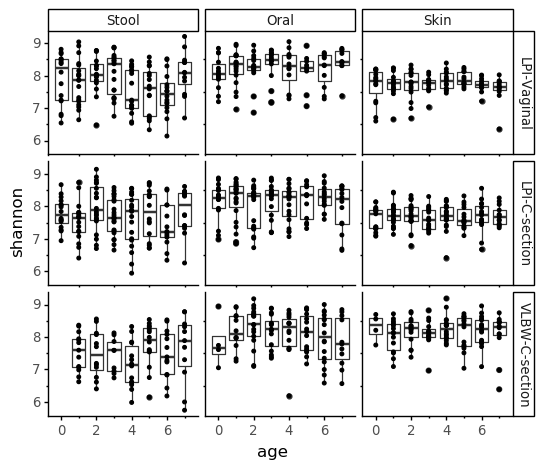

<ggplot: (-9223363306144178095)>

In [55]:
sdm_dict = {"11712_c-section": "LPI-C-section",
           "11712_vaginal":"LPI-Vaginal",
           "11713_c-section":"VLBW-C-section"}
md_alpha["study_delivery_mode"] = md_alpha.apply(axis=1, func=lambda row: sdm_dict[str(row.qiita_study_id) + "_" + row.delivery_mode])
md_alpha["study_delivery_mode"] = pd.Categorical(md_alpha["study_delivery_mode"], categories=["LPI-Vaginal","LPI-C-section","VLBW-C-section"])


md_alpha["sample_type"] = pd.Categorical(md_alpha.sample_type, categories=["Stool","Oral","Skin"])

p = (pn.ggplot(data = md_alpha) +
     pn.geom_boxplot( pn.aes(x="age", y='shannon', group="age")) +
     pn.geom_point( pn.aes(x="age", y='shannon'), size=1) +
     pn.facet_grid("study_delivery_mode~sample_type", space="free") +
     pn.theme_classic(base_size=12)
     
     
    )

p

# Fatty acids over time

In [260]:
fa_list = ["docosahexanoic",
"arachidonic",
"linoleic",
"oleic",
"palmitic"]


In [261]:
feature_md = doty_bt.metadata_to_dataframe(axis="observation")

In [262]:
fatty_acid_namess= [x for x in feature_md.Compound_Name if any([y in x.lower() for y in fa_list])]
fatty_acid_ids = set(feature_md.query('Compound_Name in @fatty_acid_namess').index)

In [301]:
doty_fa_bt = doty_bt.filter(fatty_acid_ids, axis="observation", inplace=False)
stool_samples = set (md.query('sample_type=="Stool" & qiita_study_id==11712').index)
doty_fa_bt.filter(stool_samples, inplace=True)

44 x 271 <class 'biom.table.Table'> with 447 nonzero entries (3% dense)

In [302]:
doty_fa_df = pd.DataFrame(doty_fa_bt.to_dataframe())\
.transpose().sum(axis=1)
doty_fa_df = pd.DataFrame(doty_fa_df, columns=["tot"])\
.merge(md, right_index=True, left_index=True)

fa_avg_df = doty_fa_df.groupby(['study_delivery_mode',"metadata_abx","randomization","age"]).agg({"tot":["mean","sem"]}).reset_index()
fa_avg_df.columns=['study_delivery_mode',"metadata_abx", "randomization","age","avg","err"]
fa_avg_df["err_max"] = fa_avg_df.apply(axis=1, func=lambda row: row.avg + row.err)
fa_avg_df["err_min"] = fa_avg_df.apply(axis=1, func=lambda row: row.avg - row.err)
fa_avg_df.head()

,study_delivery_mode,metadata_abx,randomization,age,avg,err,err_max,err_min
0,LPI-C-section,0.0,Donor human milk,0.0,523.002337,337.991432,860.993769,185.010905
1,LPI-C-section,0.0,Donor human milk,1.0,87.162979,61.084282,148.247261,26.078697
2,LPI-C-section,0.0,Donor human milk,2.0,1820.914515,750.968530,2571.883045,1069.945985
3,LPI-C-section,0.0,Donor human milk,3.0,3064.693379,2753.106986,5817.800365,311.586392
4,LPI-C-section,0.0,Donor human milk,4.0,5616.584569,4204.181387,9820.765956,1412.403183


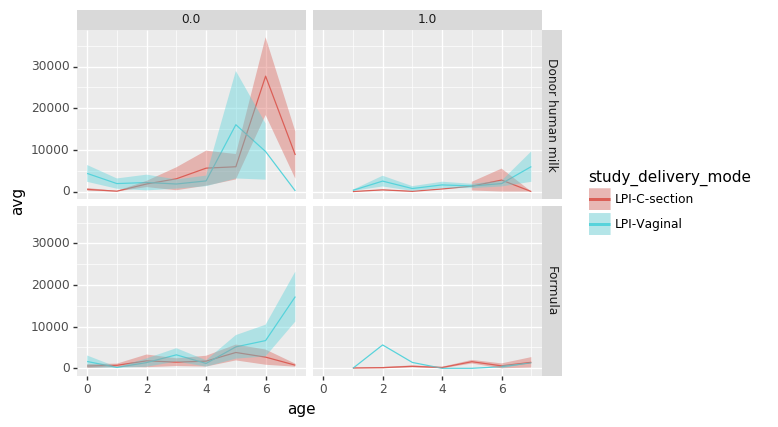

<ggplot: (8738624193856)>

In [303]:
plot_dat= fa_avg_df.copy()


p = (pn.ggplot(data=plot_dat) +
    pn.geom_line( pn.aes(x="age",y="avg", color="study_delivery_mode")) +
     pn.geom_ribbon( pn.aes(x="age",ymax="err_max",ymin="err_min", fill="study_delivery_mode"), alpha=.4) +
     pn.facet_grid('randomization~metadata_abx')
    
    )

p

In [ ]:
qza_bplts = {}
qza_dms = {}
dms = {}
biplots = {}

for study in ["doty","stillwell"]:
    qza_dms[study] = q2.Artifact.load(root_dir + "intermediate_data/20200608_{}_metabolomics_deicode_dm.qza".format(study))
    qza_bplts[study] = q2.Artifact.load(root_dir + "intermediate_data/20200608_{}_metabolomics_deicode_biplot.qza".format(study))
    dms[study] = qza_dms[study].view(DistanceMatrix).to_data_frame()
    biplots[study] = qza_bplts[study].view(OrdinationResults)

### Bile acids over time

In [98]:
feature_md = bt.metadata_to_dataframe(axis="observation")
feature_md["Bile_Acid_full_class"] = feature_md.apply(axis=1, func=lambda row: "nan" if row.Bile_Acid_Class == "nan" else row.Bile_Acid_Class + " " + row.Bile_Acid_Subclass)
bile_acids = set(feature_md.query('Bile_Acid_Class != "nan"').index)

temp_bt = bt.filter(bile_acids, inplace=False, axis="observation")
stool_samples = set(md.query('sample_type=="Stool"').index)
temp_bt.filter(stool_samples)

colors=['#377eb8',  '#4daf4a','#ff7f00','#984ea3', '#a65628',
                  '#f781bf',  
                  '#999999', '#e41a1c', '#dede00']

Bile acid subclass

In [99]:
bile_acid_df = pd.DataFrame(temp_bt.to_dataframe())\
    .reset_index()\
    .melt(id_vars=["index"])\
    .merge(feature_md, left_on="index", right_index=True)\
    .set_index("index")\
    .merge(md, left_on="variable", right_index=True)

#Make mean and sem
BA_class_df = bile_acid_df.groupby(["study_delivery_mode","age","Bile_Acid_full_class"]).agg({"value":["mean","sem"]}).reset_index()
BA_class_df.columns = ["study_delivery_mode","age","Bile_Acid_full_class","avg","err"]
BA_class_df["err_pos"] = BA_class_df.apply(axis=1, func=lambda row: row.avg + row.err)
BA_class_df["err_neg"] = BA_class_df.apply(axis=1, func=lambda row: row.avg - row.err)

In [104]:
sample_class_sum = bile_acid_df.groupby(["variable","Bile_Acid_full_class"])\
    .agg({"value":sum}).reset_index()\
    .merge(md, right_index=True, left_on="variable")


group_mean_class_abundance = sample_class_sum.groupby(["study_delivery_mode","age","metadata_abx","Bile_Acid_full_class"]).agg({"value":["mean","sem"]})

group_mean_class_abundance = group_mean_class_abundance.reset_index()
group_mean_class_abundance.columns = ["study_delivery_mode","age","metadata_abx","Bile_Acid_full_class","avg","err"]
group_mean_class_abundance["err_pos"] = group_mean_class_abundance.apply(axis=1, func=lambda row: row.avg + row.err)
group_mean_class_abundance["err_neg"] = group_mean_class_abundance.apply(axis=1, func=lambda row: row.avg - row.err)

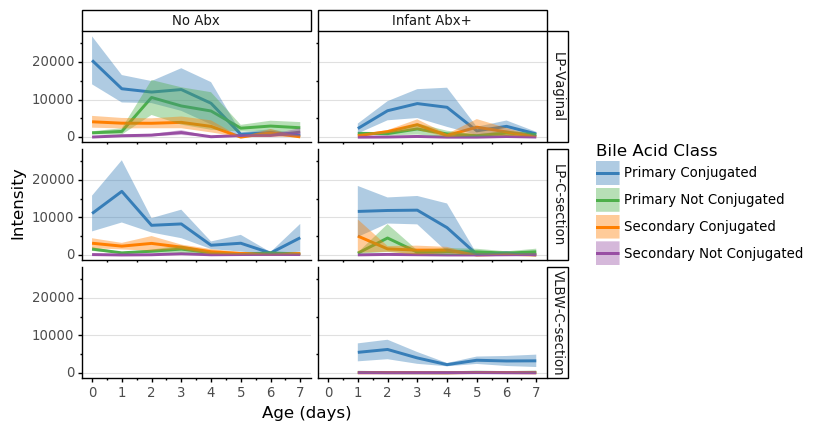

<ggplot: (8758477697463)>

In [105]:
pn.options.figure_size=(6,4.5)
plot_dat = group_mean_class_abundance.copy()
plot_dat["study_delivery_mode"] = pd.Categorical(plot_dat.study_delivery_mode, categories=["LP-Vaginal","LP-C-section","VLBW-C-section"])
plot_dat["metadata_abx"] = plot_dat.metadata_abx.replace({0:"No Abx", 1:"Infant Abx+"})
plot_dat["metadata_abx"] = pd.Categorical(plot_dat["metadata_abx"], categories=["No Abx","Infant Abx+"])


p = (pn.ggplot(data = plot_dat) +
    pn.geom_line( pn.aes( x="age", y="avg", color="Bile_Acid_full_class"), size=1.2) +
    pn.geom_ribbon( pn.aes( x="age", ymax="err_pos",ymin="err_neg", fill="Bile_Acid_full_class"), alpha=.4) +
     pn.facet_grid("study_delivery_mode~metadata_abx") +
     pn.labs(x="Age (days)", y="Intensity", color="Bile Acid Class", fill="Bile Acid Class") +
     pn.scale_x_continuous(breaks=[0,1,2,3,4,5,6,7]) +
     pn.scale_color_manual(colors) +
     pn.scale_fill_manual(colors) +
     pn.theme_classic(base_size=12) +
     pn.theme(panel_grid_major_y = pn.element_line(color="lightgrey", alpha=.7))
     
    
    )
p

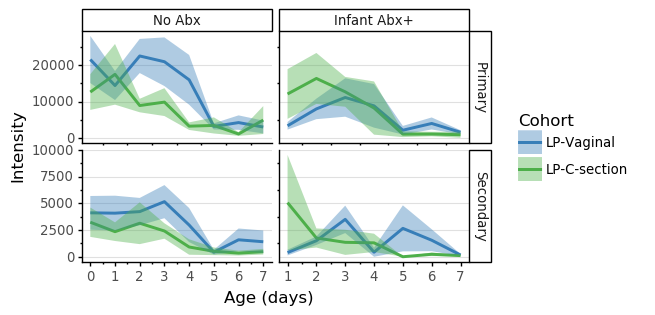

<ggplot: (8758478123882)>

In [93]:
pn.options.figure_size=(5,3)
plot_dat = group_mean_class_abundance\
    .query('study_delivery_mode!="VLBW-C-section"')\
    .copy()
plot_dat["study_delivery_mode"] = pd.Categorical(plot_dat.study_delivery_mode, categories=["LP-Vaginal","LP-C-section"])
plot_dat["metadata_abx"] = plot_dat.metadata_abx.replace({0:"No Abx", 1:"Infant Abx+"})
plot_dat["metadata_abx"] = pd.Categorical(plot_dat["metadata_abx"], categories=["No Abx","Infant Abx+"])


p = (pn.ggplot(data = plot_dat) +
    pn.geom_line( pn.aes( x="age", y="avg", color="study_delivery_mode"), size=1.2) +
    pn.geom_ribbon( pn.aes( x="age", ymax="err_pos",ymin="err_neg", fill="study_delivery_mode"), alpha=.4) +
     pn.facet_grid("Bile_Acid_Class~metadata_abx", scales="free") +
     pn.labs(x="Age (days)", y="Intensity", color="Cohort", fill="Cohort") +
     pn.scale_x_continuous(breaks=[0,1,2,3,4,5,6,7]) +
     pn.scale_color_manual(colors) +
     pn.scale_fill_manual(colors) +
     pn.theme_classic(base_size=12) +
     pn.theme(panel_grid_major_y = pn.element_line(color="lightgrey", alpha=.7))
     
    
    )
p

Group by bile acid

In [41]:
#Make mean and sem
BA_annotation_df = bile_acid_df.groupby(["study_delivery_mode","age","Annotation"]).agg({"value":["mean","sem"],"Bile_Acid_Class":"first"}).reset_index()
BA_annotation_df.columns = ["study_delivery_mode","age","Annotation","avg","err","Bile_Acid_Class"]
BA_annotation_df["err_pos"] = BA_annotation_df.apply(axis=1, func=lambda row: row.avg + row.err)
BA_annotation_df["err_neg"] = BA_annotation_df.apply(axis=1, func=lambda row: row.avg - row.err)

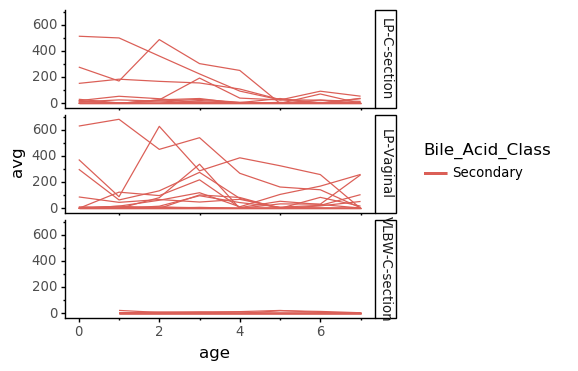

<ggplot: (-9223363267350041421)>

In [42]:
pn.options.figure_size=(4,4)
plot_dat = BA_annotation_df.query('Bile_Acid_Class=="Secondary"')

p = (pn.ggplot(data = plot_dat) +
    pn.geom_line( pn.aes( x="age", y="avg", group="Annotation",color="Bile_Acid_Class")) +
    #pn.geom_ribbon( pn.aes( x="age", ymax="err_pos",ymin="err_neg", group="Annotation",fill="Bile_Acid_Class"), alpha=.4) +
     pn.facet_grid("study_delivery_mode~.") +
     pn.theme_classic(base_size=12)
     
    
    )
p

Presence absense

In [50]:
#Convert to 1/0
freq = lambda x: sum(x>0)/len(x)
bile_acid_df_prev = bile_acid_df.copy()
bile_acid_df_prev["value"] = [1 if x > 0 else 0 for x in bile_acid_df_prev.value]

by_individual = bile_acid_df_prev.groupby(["host_subject_id","age","metadata_abx","Bile_Acid_Class"]).agg({"value":"sum","study_delivery_mode":"first"})
by_individual["value"] = [1 if x > 0 else 0 for x in by_individual.value]

freq_by_cohort = by_individual.groupby(["study_delivery_mode","age","metadata_abx","Bile_Acid_Class"]).agg({"value":freq}).reset_index()

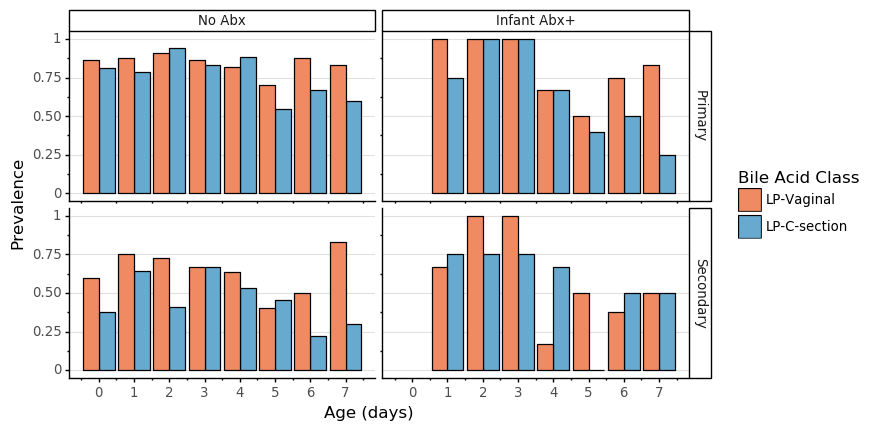

<ggplot: (-9223363278377582767)>

In [94]:
pn.options.figure_size=(8,4.5)
plot_dat = freq_by_cohort.query('study_delivery_mode!= "VLBW-C-section"').copy()
plot_dat["study_delivery_mode"] = pd.Categorical(plot_dat.study_delivery_mode, categories=["LP-Vaginal","LP-C-section"])
plot_dat["metadata_abx"] = plot_dat.metadata_abx.replace({0:"No Abx", 1:"Infant Abx+"})
plot_dat["metadata_abx"] = pd.Categorical(plot_dat["metadata_abx"], categories=["No Abx","Infant Abx+"])

plot_dat = plot_dat

p = (pn.ggplot(data = plot_dat) +
    pn.geom_bar( pn.aes( x="age", y="value", fill="study_delivery_mode"), 
                size=.5, stat="identity", position="dodge", color="black") +
     pn.facet_grid("Bile_Acid_Class~metadata_abx") +
     pn.theme_classic(base_size=12)+
     pn.labs(x="Age (days)", y="Prevalence", color="Bile Acid Class", fill="Bile Acid Class") +
     pn.scale_x_continuous(breaks=[0,1,2,3,4,5,6,7]) +
     pn.scale_color_manual(colors) +
     pn.scale_fill_manual(["#ef8a62","#67a9cf"]) +
     pn.theme_classic(base_size=12) +
     pn.theme(panel_grid_major_y = pn.element_line(color="lightgrey", alpha=.7))
     
    
    )
p

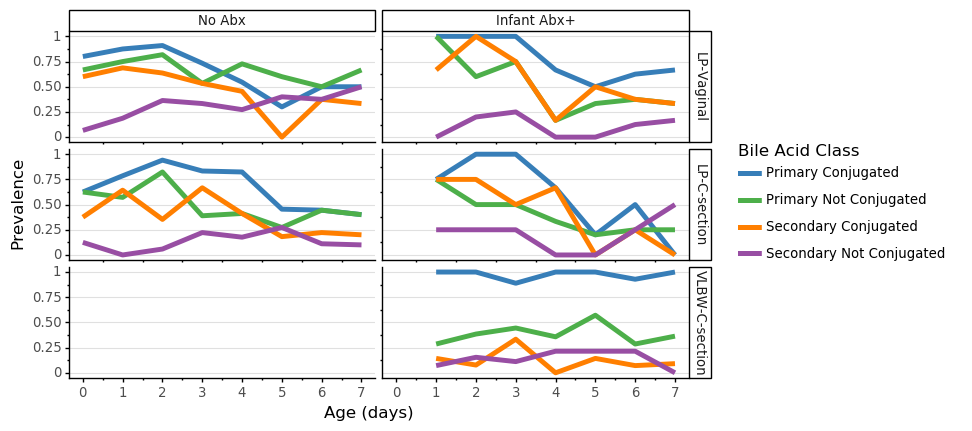

<ggplot: (8769510022860)>

In [49]:
pn.options.figure_size=(8,4.5)
plot_dat = freq_by_cohort.copy()
plot_dat["study_delivery_mode"] = pd.Categorical(plot_dat.study_delivery_mode, categories=["LP-Vaginal","LP-C-section","VLBW-C-section"])
plot_dat["metadata_abx"] = plot_dat.metadata_abx.replace({0:"No Abx", 1:"Infant Abx+"})
plot_dat["metadata_abx"] = pd.Categorical(plot_dat["metadata_abx"], categories=["No Abx","Infant Abx+"])

p = (pn.ggplot(data = plot_dat) +
    pn.geom_line( pn.aes( x="age", y="value", color="Bile_Acid_full_class"), 
                size=2) +
     pn.facet_grid("study_delivery_mode~metadata_abx") +
     pn.theme_classic(base_size=12)+
     pn.labs(x="Age (days)", y="Prevalence", color="Bile Acid Class", fill="Bile Acid Class") +
     pn.scale_x_continuous(breaks=[0,1,2,3,4,5,6,7]) +
     pn.scale_color_manual(colors) +
     pn.scale_fill_manual(colors) +
     pn.theme_classic(base_size=12) +
     pn.theme(panel_grid_major_y = pn.element_line(color="lightgrey", alpha=.7))
     
    
    )
p

Number of bile acids seen

In [50]:
#Convert to 1/0
bile_acid_df_prev = bile_acid_df.copy()
bile_acid_df_prev["value"] = [1 if x > 0 else 0 for x in bile_acid_df_prev.value]

by_individual = bile_acid_df_prev.groupby(["host_subject_id","age","Bile_Acid_full_class"]).agg({"value":"sum","study_delivery_mode":"first","metadata_abx":"first"})


num_by_cohort = by_individual.groupby(["study_delivery_mode","age","metadata_abx","Bile_Acid_full_class"]).agg({"value":["mean", "sem"]}).reset_index()
num_by_cohort.columns = ['study_delivery_mode','age','metadata_abx','Bile_Acid_full_class','ct','err']

num_by_cohort["err_pos"] = num_by_cohort.apply(axis=1, func=lambda row: row.ct + row.err)
num_by_cohort["err_neg"] = num_by_cohort.apply(axis=1, func=lambda row: row.ct - row.err)

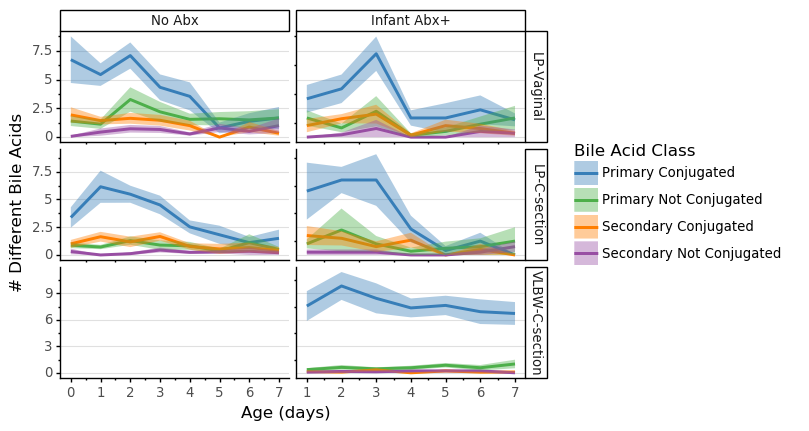

<ggplot: (-9223363267350666380)>

In [51]:
pn.options.figure_size=(6,4.5)
plot_dat = num_by_cohort.copy()
plot_dat["study_delivery_mode"] = pd.Categorical(plot_dat.study_delivery_mode, categories=["LP-Vaginal","LP-C-section","VLBW-C-section"])
plot_dat["metadata_abx"] = plot_dat.metadata_abx.replace({0:"No Abx", 1:"Infant Abx+"})
plot_dat["metadata_abx"] = pd.Categorical(plot_dat["metadata_abx"], categories=["No Abx","Infant Abx+"])

p = (pn.ggplot(data = plot_dat) +
    pn.geom_line( pn.aes( x="age", y="ct", color="Bile_Acid_full_class"), size=1.2) +
    pn.geom_ribbon( pn.aes( x="age", ymax="err_pos",ymin="err_neg", fill="Bile_Acid_full_class"), alpha=.4) +
     pn.facet_grid("study_delivery_mode~metadata_abx", scales="free") +
     pn.labs(x="Age (days)", y="# Different Bile Acids", color="Bile Acid Class", fill="Bile Acid Class") +
     pn.scale_x_continuous(breaks=[0,1,2,3,4,5,6,7]) +
     pn.scale_color_manual(colors) +
     pn.scale_fill_manual(colors) +
     pn.theme_classic(base_size=12) +
     pn.theme(panel_grid_major_y = pn.element_line(color="lightgrey", alpha=.7))
     
    
    )
p

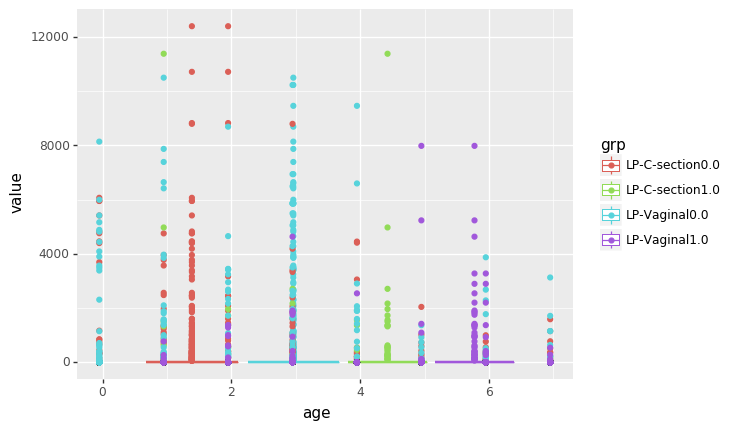

<ggplot: (-9223363278339026821)>

In [40]:
plot_dat = bile_acid_df.query('Bile_Acid_Class=="Secondary" & study_delivery_mode!="VLBW-C-section"').copy()
plot_dat["grp"] = plot_dat.apply(axis=1, func= lambda row: row.study_delivery_mode + str(row.metadata_abx))


p = (pn.ggplot( data = plot_dat ) +
     pn.geom_boxplot( pn.aes( x="age", y="value", color="grp")) +
     pn.geom_point( pn.aes(x = "age", y="value", color="grp"), position=pn.position_dodge2(width=.1)) 
    )

p

In [ ]:
z

In [190]:
md.query('qiita_study_id==11713').host_subject_id.value_counts()

11713-17    21
11713-18    20
11713-4     20
11713-25    20
11713-8     19
11713-20    18
11713-16    18
11713-10    17
11713-5     17
11713-22    17
11713-13    17
11713-11    16
11713-15    16
11713-12    16
11713-1     16
11713-21    13
11713-3     13
11713-14    12
Name: host_subject_id, dtype: int64

In [189]:
bile_acid_df_prev.query('host_subject_id=="11713-20" & age==2 & value >0').Bile_Acid_full_class.value_counts()

Primary Conjugated    13
Name: Bile_Acid_full_class, dtype: int64

In [191]:
bile_acid_df_prev.query('host_subject_id=="11713-18" & age==2 & value >0').Bile_Acid_full_class.value_counts()

Primary Conjugated          10
Primary Not Conjugated       1
Secondary Not Conjugated     1
Name: Bile_Acid_full_class, dtype: int64

In [193]:
bile_acid_df_prev.query('host_subject_id=="11713-13" & age==2 & value >0').Bile_Acid_full_class.value_counts()

Primary Conjugated    12
Name: Bile_Acid_full_class, dtype: int64

In [189]:
bile_acid_df_prev.query('host_subject_id=="11713-20" & age==2 & value >0').Bile_Acid_full_class.value_counts()

Primary Conjugated    13
Name: Bile_Acid_full_class, dtype: int64

In [106]:
ls ..

20200601_consolidated_analyses.ipynb*         metadata/
20200601_CONSORT_diagram_R.ipynb*             raw_data/
20200601_preterm_infants_demographics.ipynb*  results/
bile_acid_export.tsv                          sw_notebooks/
consort/                                      table_test.html
intermediate_data/                            table_test.txt


In [109]:
bile_acid_export = pd.read_csv("../bile_acid_export.tsv", sep='\t', index_col=0)\
    .merge(md, right_index=True, left_index=True)
bile_acid_export = bile_acid_export.loc[bile_acid_export.Current_Natural_Log_Ratio.notna()]

In [132]:
lm_list=[]

for cohort in set(bile_acid_export.study_delivery_mode):
    for abx in [0,1]:
        dat_ss = bile_acid_export.query('study_delivery_mode==@cohort & metadata_abx==@abx ')
        X = dat_ss.age_x
        y = dat_ss.Current_Natural_Log_Ratio

        X2 = sm.add_constant(X)
        est = sm.OLS(y, X2)

        intercept = float(est.fit().summary().tables[1].data[1][1])
        slope = float(est.fit().summary().tables[1].data[2][1])
        pvalue=est.fit().f_pvalue
        Rsq = est.fit().summary().tables[0].data[0][3]

        lm_list.append([study,cohort,abx, intercept,slope,Rsq, pvalue])

lm_df = pd.DataFrame(lm_list, columns=["study","study_delivery_mode","metadata_abx","intercept","slope","R2", "p"])

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


In [133]:
lm_df

,study,study_delivery_mode,metadata_abx,intercept,slope,R2,p
0,11713,LP-C-section,0,-1.4504,0.0928,0.022,0.301984
1,11713,LP-C-section,1,-2.0130,0.0235,0.002,0.878528
2,11713,LP-Vaginal,0,-1.9718,0.1688,0.129,0.005682
3,11713,LP-Vaginal,1,-1.7738,0.1610,0.050,0.356344


In [141]:
bile_acid_export.groupby(["study_delivery_mode","metadata_abx"]).age_x.value_counts()

study_delivery_mode  metadata_abx  age_x
LP-C-section         0.0           3        11
                                   1         9
                                   4         9
                                   2         7
                                   0         6
                                   5         4
                                   7         3
                                   6         2
                     1.0           1         3
                                   2         3
                                   3         2
                                   4         2
                                   6         2
                                   7         1
LP-Vaginal           0.0           1        12
                                   0        10
                                   3         9
                                   2         8
                                   4         7
                                   5         4
                   

In [158]:
lm_df

,study,study_delivery_mode,metadata_abx,intercept,slope,R2,p,all_info,p_text,sig
0,11713,LP-C-section,0,-1.4504,0.0928,0.022,0.301984,R2=0.022\nslope=0.0928,p=0.302,False
1,11713,LP-C-section,1,-2.0130,0.0235,0.002,0.878528,R2=0.002\nslope=0.0235,p=0.879,False
2,11713,LP-Vaginal,0,-1.9718,0.1688,0.129,0.005682,R2=0.129\nslope=0.1688,p=0.006,True
3,11713,LP-Vaginal,1,-1.7738,0.1610,0.050,0.356344,R2=0.050\nslope=0.161,p=0.356,False


In [157]:
lm_df["all_info"] = lm_df.apply(axis=1, func=lambda row: "R2={}\nslope={}".format(row.R2.strip(),row.slope))
lm_df['p_text'] = ["p={}".format(round(x,3)) for x in lm_df.p]
lm_df["sig"] = lm_df.p < .05

In [182]:
bile_acid_export["study_delivery_mode"] = pd.Categorical(bile_acid_export.study_delivery_mode, categories=["LP-Vaginal","LP-C-section"])
bile_acid_export["abx_label"] = pd.Categorical(["No Abx" if x==0 else "Infant Abx+" for x in bile_acid_export.metadata_abx], categories=["No Abx","Infant Abx+"])
lm_df["abx_label"] = pd.Categorical(["No Abx" if x==0 else "Infant Abx+" for x in lm_df.metadata_abx], categories=["No Abx","Infant Abx+"])
lm_df["study_delivery_mode"] = pd.Categorical(lm_df.study_delivery_mode, categories=["LP-Vaginal","LP-C-section"])


/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6 x 4.5 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /projects/cmi_proj/seed_grants/Infant_Studies/Jae_Kim/nature_med_consolidated_analyses/results/figures/svg/bile_acid_log_ratio.svg
  warn('Filename: {}'.format(filename), PlotnineWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_boxplot : Removed 1 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 1 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6

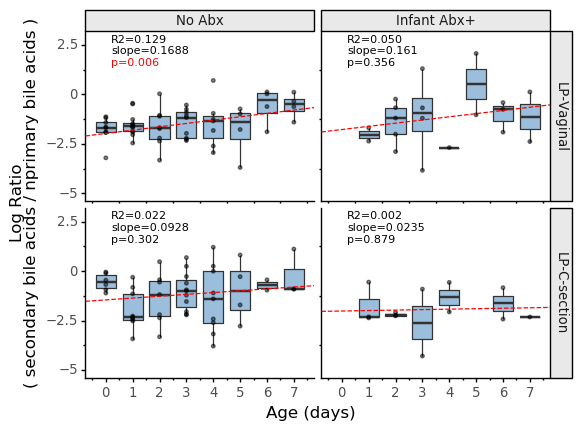

<ggplot: (-9223363278337299740)>

In [192]:
p = ( pn.ggplot(data = bile_acid_export) +
    pn.geom_boxplot( pn.aes(x="age_x", y="Current_Natural_Log_Ratio", group="age_x"), outlier_alpha=0, fill='#377eb8', alpha=.5) +
      pn.geom_point( pn.aes(x="age_x", y="Current_Natural_Log_Ratio"), size=1, alpha=.5) +
     pn.geom_abline(data = lm_df,  mapping=pn.aes(intercept="intercept", slope="slope"), color="red",linetype="dashed") +
     pn.geom_text(data = lm_df, mapping = pn.aes(x=.2,y=2.5, label="all_info"),size=8, hjust="left") +
     pn.geom_text(data = lm_df, mapping = pn.aes(x=.2,y=1.6, label="p_text", color="sig"),size=8, hjust="left") +
     pn.facet_grid("study_delivery_mode~abx_label") +
    # pn.scale_fill_manual(values=colors) +
     pn.scale_color_manual(values=["black","red"]) +
     pn.guides(color=None) +
    pn.scale_y_continuous(limits=[-5,2.8]) +
     pn.scale_x_continuous(breaks=[0,1,2,3,4,5,6,7]) +
     pn.labs(x="Age (days)", y="Log Ratio\n( secondary bile acids / nprimary bile acids )") +
     pn.theme_classic(base_size=12) +
     pn.theme(strip_background=pn.element_rect(fill="#E9E9E9"))
     
    )

p.save(root_dir + "results/figures/svg/bile_acid_log_ratio.svg", dpi=300)
p.save(root_dir + "results/figures/bile_acid_log_ratio.pdf", dpi=300)
p